In [1184]:
import pandas as pd
import lightgbm as lgb
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from script.helper import *
from datetime import datetime, date, time, timedelta
import os
import glob
import datetime
import plotly.plotly as py
import plotly.graph_objs as go
from matplotlib import pyplot as plt
import pandas as pd
from datetime import datetime
import plotly
import plotly.io as pio
import psutil
import seaborn as sns
plotly.tools.set_credentials_file(username='wpqppeqq', api_key='Xeob9qhAxp7DCAyB9K1d')
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import xgboost as xgb
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [1018]:
dow_dict = {1: 'Mon', 2:'Tue', 3:'Wed', 4:'Thur', 5:'Fri', 6:'Sat', 7:'Sun'}

# Separate

In [58]:
for file in glob.glob('./data/Metro_train/*.csv'):
#for file in glob.glob('./data/Metro_testA/testA_record_2019-01-28.csv'):
    print(file)
    df = pd.read_csv(file)
                     
    raw_times = pd.to_datetime(df['time'], format="%Y/%m/%d %H:%M:%S")
    new_times = []
    for time in log_progress(raw_times, every = 100000):
        x = time
        minutes = x.minute
        new_minutes = int(minutes / 10) * 10
        x = x.replace(minute = new_minutes).replace(second = 0)
        new_times.append(x)
    df['time'] = new_times
    
    counts = df.groupby(['time', 'lineID', 'stationID'], as_index=False).\
                agg({'status':[np.sum, lambda x: len(x) - sum(x)]})
    counts.columns = counts.columns.droplevel()
    counts.columns = ['time','line','stationID','in','out']
    counts.to_csv('./processed_data/' + file.split('/')[-1])

./data/Metro_testA/testA_record_2019-01-28.csv


# Merge

In [114]:
all_counts = pd.DataFrame(columns = ['time','line','stationID','in','out'])
for file in glob.glob('./processed_data/*.csv'):
    temp_df = pd.read_csv(file)[all_counts.columns]
    all_counts = pd.concat([all_counts, temp_df], axis = 0, sort=True, ignore_index = True)[all_counts.columns]
all_counts['time'] = pd.to_datetime(all_counts['time'], format="%Y/%m/%d %H:%M:%S")

In [115]:
all_stations = list(set(all_counts['stationID']))
sta2line = {k:v for k, v in list(set([(x,y) for x,y in zip(all_counts['stationID'], all_counts['line'])]))}

In [116]:
zero_counts = []
skip = False
start = pd.Timestamp('2019-01-01 00:00:00')
while(start.day <= 28):
    #print(start)
    nonzero_stations = set(all_counts[all_counts['time'] == str(start)]['stationID'])
    for stationID in all_stations:
        if stationID not in nonzero_stations:
            zero_counts.append([start, sta2line[stationID], stationID, 0, 0])
    start = start + timedelta(minutes=10)
    if start.day > 25 and skip == False:
        start = start + timedelta(days=2)
        skip = True

In [117]:
zero_counts_df = pd.DataFrame(zero_counts, columns = all_counts.columns)
all_counts_merged = pd.concat([all_counts, zero_counts_df], axis = 0, sort=True, ignore_index = True)

In [120]:
len(all_counts_merged) # 299520

299520

In [159]:
299520 / 6/ 24 / 80

26.0

In [121]:
all_counts_merged.to_csv('./processed_data/all_counts_merged.csv', index = False)

# Explore

In [1267]:
df = pd.read_csv('./processed_data/all_counts_merged.csv')

In [1268]:
df['time'] = pd.to_datetime(df['time'], format="%Y/%m/%d %H:%M:%S")

In [1269]:
df['dow'] = df['time'].dt.dayofweek+1

In [1270]:
df['no_week'] = df['time'].dt.weekofyear

In [1271]:
df['time_only'] = df['time'].dt.time
df['time_only'] = df.apply(lambda row: '2019/01/' + str(13+row['dow']) + ' ' + str(row['time_only']), axis = 1)
df['time_only'] = pd.to_datetime(df['time_only'], format="%Y/%m/%d %H:%M:%S")

In [1272]:
df.head()

,in,line,out,stationID,time,dow,no_week,time_only
0,1,A,1,80,2019-01-23,3,4,2019-01-16
1,0,B,2,0,2019-01-23,3,4,2019-01-16
2,0,B,4,1,2019-01-23,3,4,2019-01-16
3,0,B,4,2,2019-01-23,3,4,2019-01-16
4,2,B,2,3,2019-01-23,3,4,2019-01-16


## By Station

In [1273]:
def plot_station(flow, stationID, df):
    sns.set(style="whitegrid")
    title_name = 'Line_' + sta2line[stationID] + '_Station_' + str(stationID) + '_Flow_' + flow 
    plt.figure(figsize=(20,6))
    test = df[(df['stationID'] == stationID) & (df['dow'] <=2) & (df['no_week'] > 1)].sort_values(by = 'time')
    plt.title(title_name)
    fig = sns.lineplot(data = test, x = 'time_only', y = flow, hue = 'no_week', palette='rainbow',estimator=None)
    fig.get_figure().savefig('./images/' + title_name + '.png')

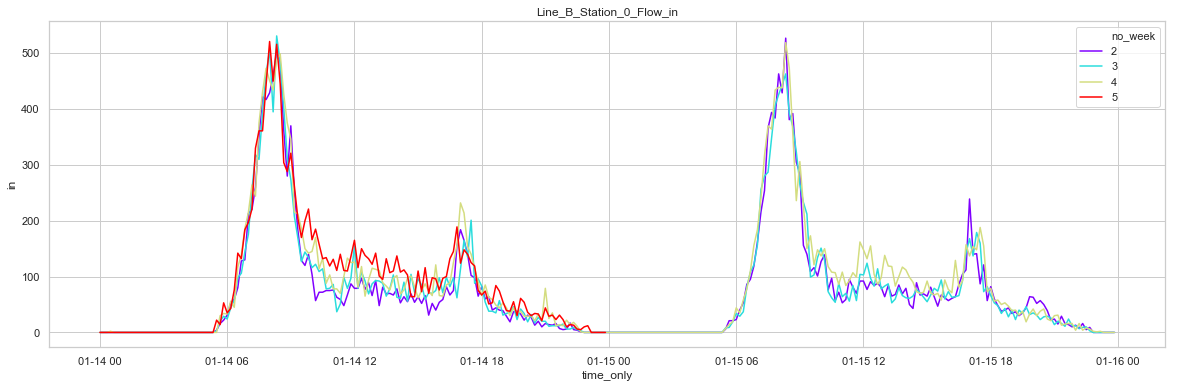

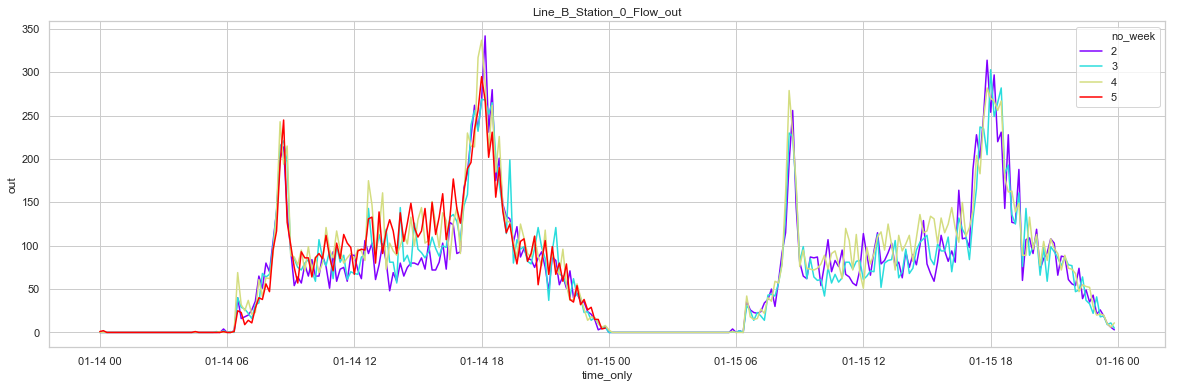

In [1274]:
for stationID in list(set(df['stationID']))[:1]:
    for flow in ['in','out']:
        plot_station(flow, stationID, df)

In [9]:
traces = []
for no_week in range(1,5):
    test = df[(df['stationID'] == 80) & (df['no_week'] == no_week)].sort_values(by = 'time')
    traces.append(go.Scatter(x=test['time_only'], y=test['in'], name = 'Week No. ' + str(no_week)))
    layout = dict(
        title='Time Series with Rangeslider',
        xaxis=dict(
            rangeslider=dict(
                visible = True
            ),
            type='date'
        )
    )
    
fig = dict(data=traces, layout=layout)
py.iplot(fig, filename = "Time Series with Rangeslider")

## By Line

In [1275]:
def plot_line(flow, line, df):
    sns.set(style="whitegrid")
    title_name = 'Line_' + line + '_Flow_' + flow 
    plt.figure(figsize=(20,6))
    test = df[(df['line'] == line) & (df['no_week'] > 1)].sort_values(by = 'time')
    test = test.groupby(['stationID','no_week'], as_index=False).agg({'in':np.mean,'out':np.mean})
    plt.title(title_name)
    fig = sns.lineplot(data = test, x = 'stationID', y = flow, hue = 'no_week', palette='rainbow',estimator=None)
    #fig.get_figure().savefig('./images/' + title_name + '.png')

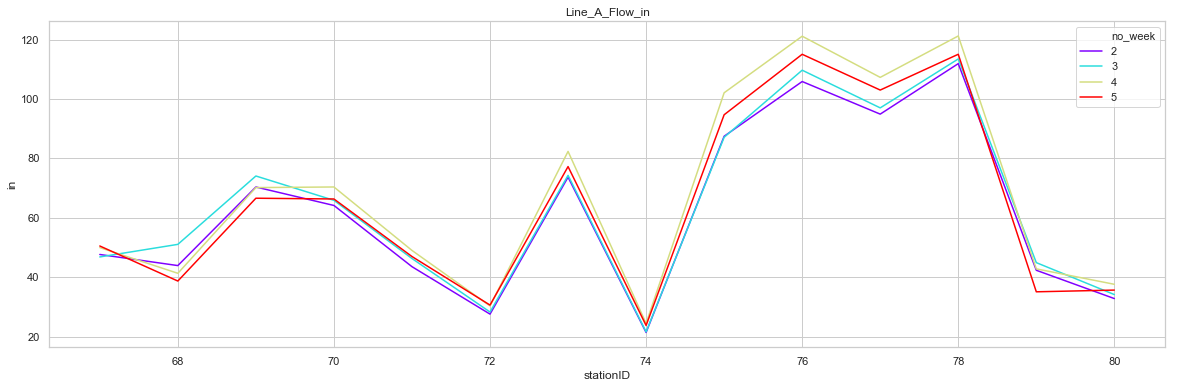

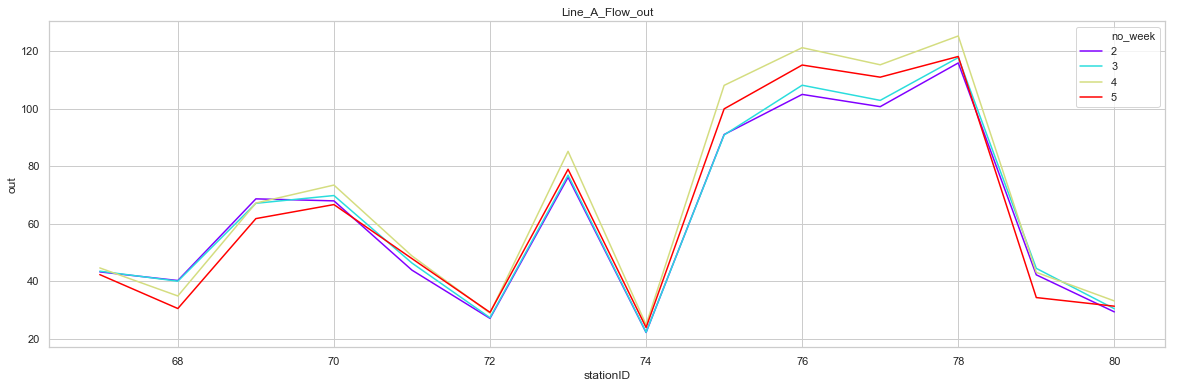

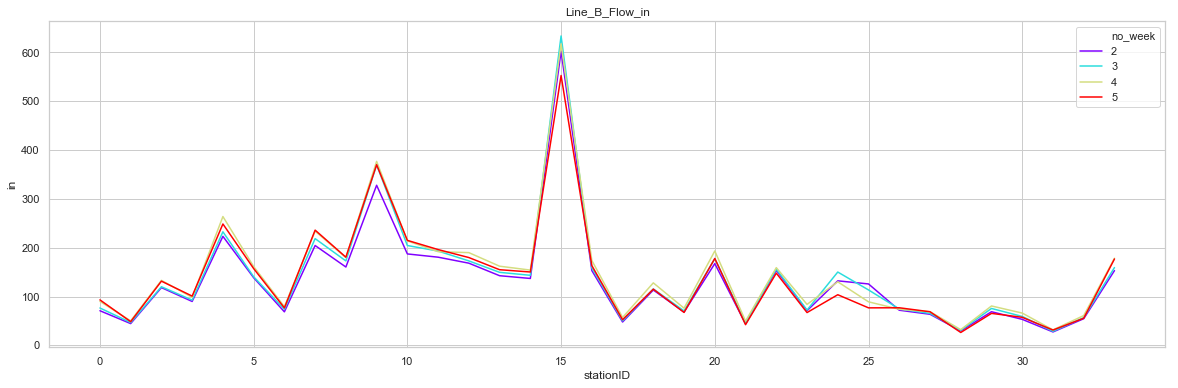

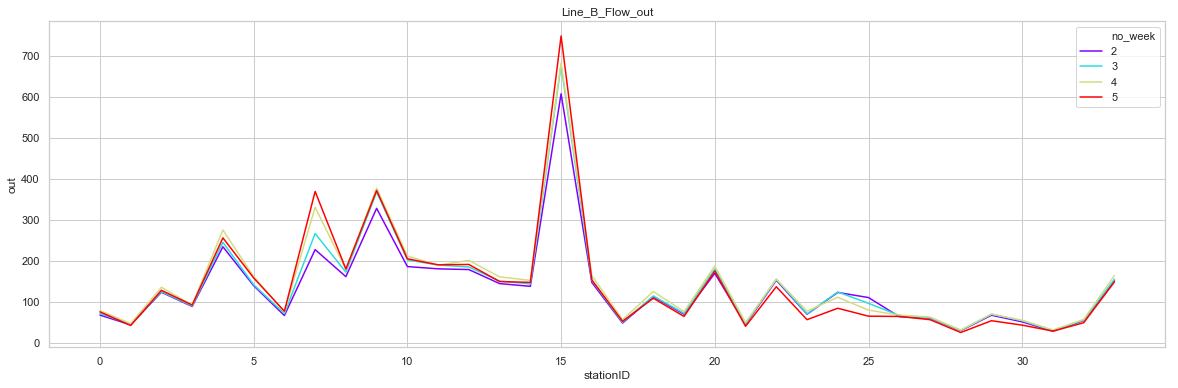

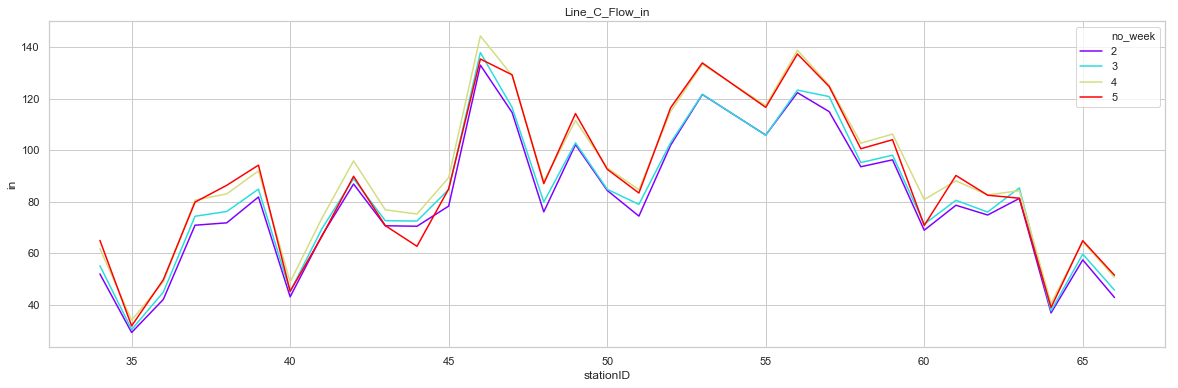

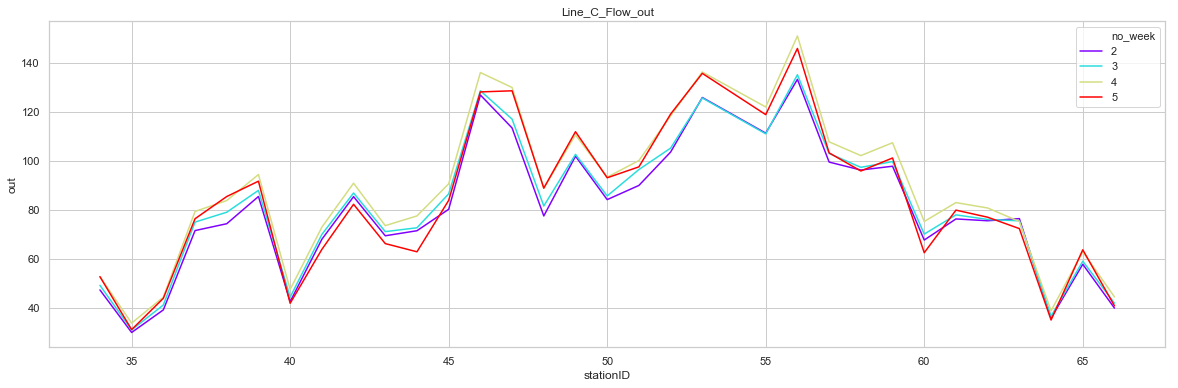

In [1276]:
for line in ['A','B','C']:
    for flow in ['in','out']:
        plot_line(flow, line, df)

## By DoW

In [1277]:
def plot_dow(flow, line, df):
    sns.set(style="whitegrid")
    title_name = 'Line_' + line + '_Flow_' + flow 
    plt.figure(figsize=(20,6))
    test = df[(df['line'] == line) & (df['no_week'] > 1)].sort_values(by = 'time')
    test = test.groupby(['stationID','dow'], as_index=False).agg({'in':np.mean,'out':np.mean})
    test['dow'] = [dow_dict[x] for x in test['dow']]
    test['size'] = [100 if x == 'Tue' else 1 for x in test['dow']]
    plt.title(title_name)
    fig = sns.lineplot(data = test, x = 'stationID', y = flow, hue = 'dow', 
                        sizes=(2,10), palette='rainbow',size='size', estimator=None)

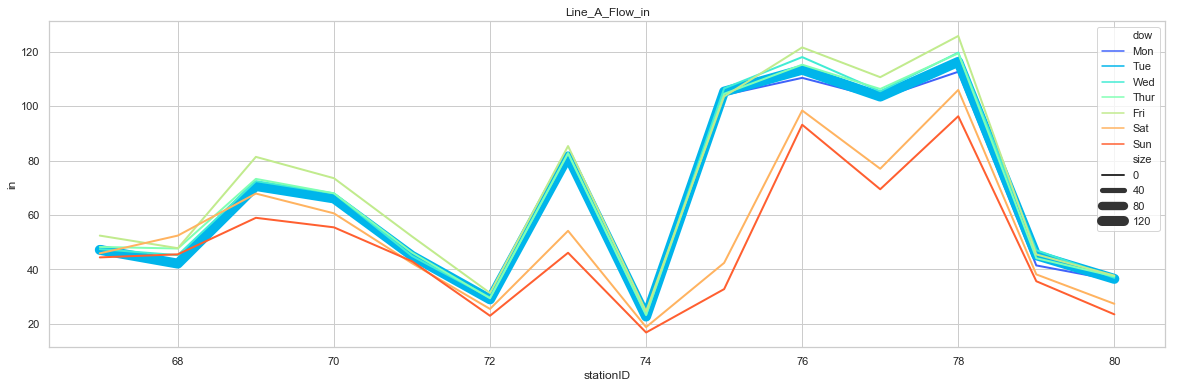

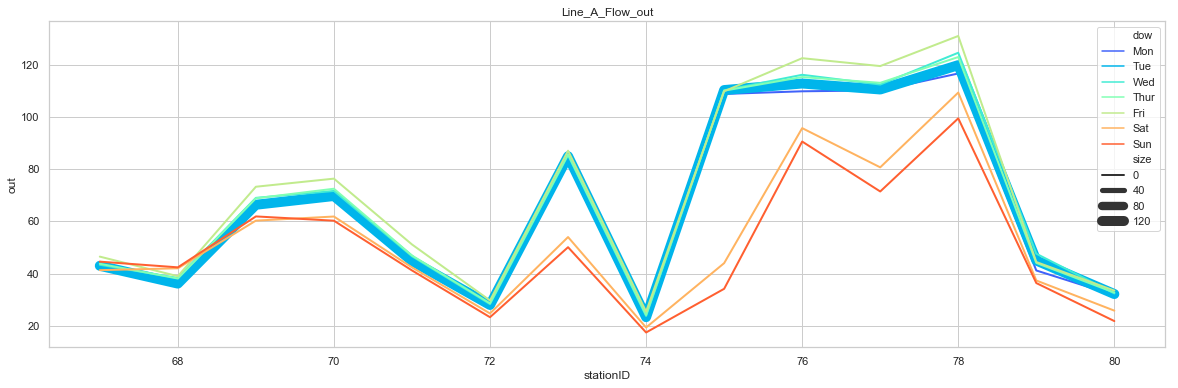

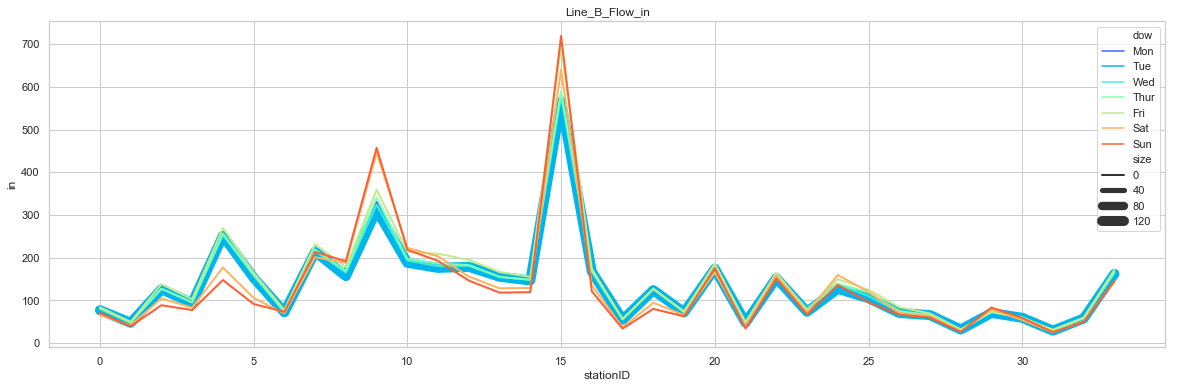

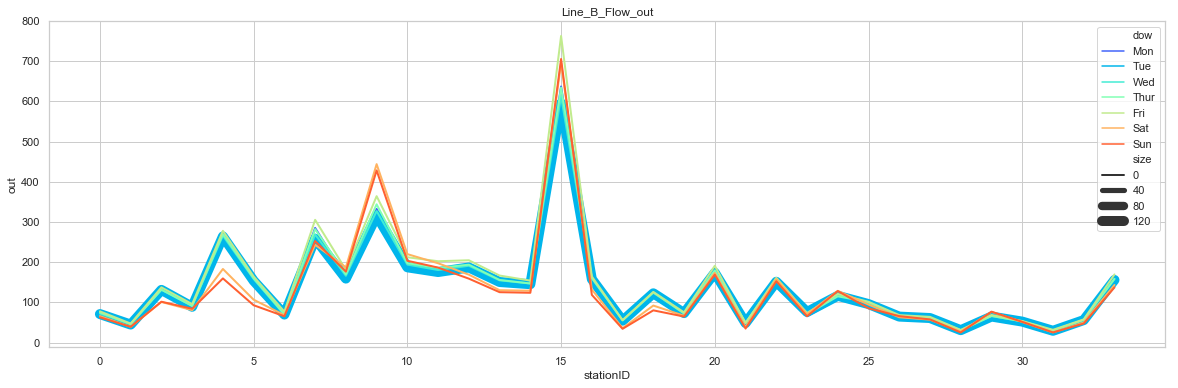

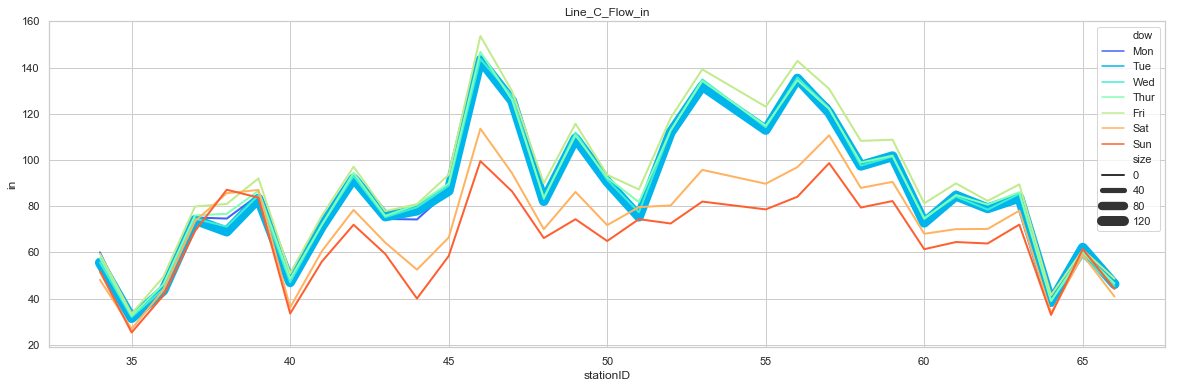

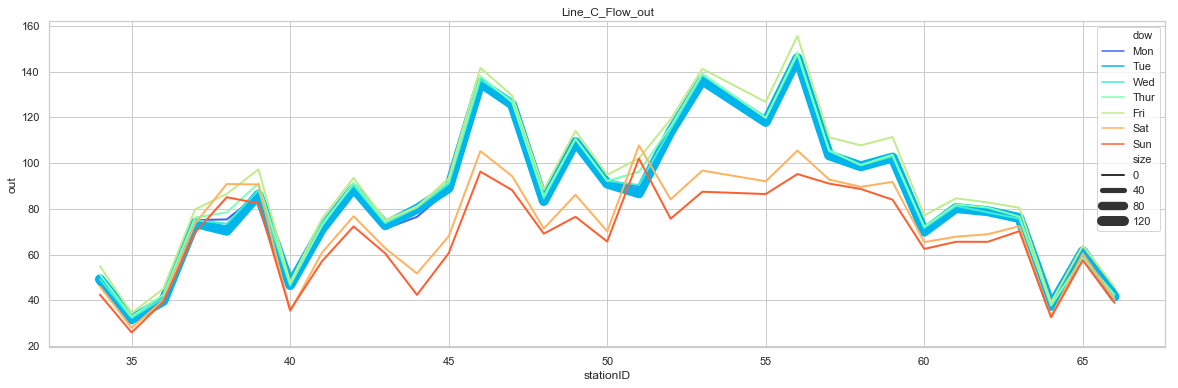

In [1278]:
for line in ['A','B','C']:
    for flow in ['in','out']:
        plot_dow(flow, line, df)

# Prepare for model

## GBT

In [1444]:
predictions = dict()
scores = dict()

- Remove 1st week
- Remove Fri, Sat, Sun

In [1930]:
data = df[(df['no_week'] > 1) & \
          (df['dow'].isin([1,2,3,4]))]

- Select Flow

In [1931]:
columns = ['in']
lines = ['A','B','C']

- Add line and filter

In [1932]:
data['line'] = [sta2line[x] for x in data['stationID']]

In [1933]:
data = data[data['line'].isin(lines)]

- Flatten df

In [1934]:
data.index = pd.MultiIndex.from_tuples(list(zip(*[data['time_only'],data['stationID'],data['no_week']])), 
                                           names=['time_only','stationID','no_week'])
data = data[columns]
data = data.unstack(level=-1)

In [1935]:
data.columns = data.columns.droplevel()
data = data.reset_index()
data.index.name='index'

In [1936]:
data['time'] = data['time_only'].dt.time
data['dow'] = data['time_only'].dt.dayofweek + 1
del data['time_only']
data.columns = ['stationID','W2','W3','W4','W5','time','dow']

- Day of week for week 2,3,4,5

In [1937]:
data = data.sort_values(by = ['dow', 'stationID', 'time']).reset_index(drop=True)
data.head()

,stationID,W2,W3,W4,W5,time,dow
0,0,0.0,0.0,0.0,0.0,00:00:00,1
1,0,0.0,0.0,0.0,0.0,00:10:00,1
2,0,0.0,0.0,0.0,0.0,00:20:00,1
3,0,0.0,0.0,2.0,0.0,00:30:00,1
4,0,0.0,0.0,0.0,0.0,00:40:00,1


In [1938]:
result = pd.DataFrame()
start = 0
while start < len(data):
    end = start + 144 # 24 * 6
    temp = data.iloc[start:end].copy()
    for col in ['W2','W3','W4','W5']:
        array = list(temp[col])
        temp.loc[:,col + '+1'] = [0] + array[:-1]
        temp.loc[:,col + '+2'] = [0,0] + array[:-2]
        temp.loc[:,col + '-1'] = array[1:] + [0]
        temp.loc[:,col + '-2'] = array[2:] + [0,0]
    try:
        result = pd.concat([result, temp], 
                           axis = 0, sort=True, ignore_index = True)
    except:
        result = temp
    start += 144

- Up/Down 5,10 minutes

In [1939]:
result.head()

,W2,W2+1,W2+2,W2-1,W2-2,W3,W3+1,W3+2,W3-1,W3-2,...,W4-1,W4-2,W5,W5+1,W5+2,W5-1,W5-2,dow,stationID,time
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,00:00:00
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1,0,00:10:00
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,00:20:00
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,00:30:00
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,00:40:00


- Previous Day

In [1940]:
tmp = result.copy()
tmp['dow'] = tmp['dow'] + 1
tmp['dow'].value_counts()

5    11520
4    11520
3    11520
2    11520
Name: dow, dtype: int64

- Collect stats columns

In [1941]:
stat_columns = [x for x in tmp.columns if 'W' in x]
stat_columns

['W2',
 'W2+1',
 'W2+2',
 'W2-1',
 'W2-2',
 'W3',
 'W3+1',
 'W3+2',
 'W3-1',
 'W3-2',
 'W4',
 'W4+1',
 'W4+2',
 'W4-1',
 'W4-2',
 'W5',
 'W5+1',
 'W5+2',
 'W5-1',
 'W5-2']

In [1942]:
for col in stat_columns:
    tmp.rename(columns={col: col+'_last'}, inplace=True) 

In [1943]:
tmp.head()

,W2_last,W2+1_last,W2+2_last,W2-1_last,W2-2_last,W3_last,W3+1_last,W3+2_last,W3-1_last,W3-2_last,...,W4-1_last,W4-2_last,W5_last,W5+1_last,W5+2_last,W5-1_last,W5-2_last,dow,stationID,time
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,00:00:00
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2,0,00:10:00
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,00:20:00
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,00:30:00
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,00:40:00


- Merge with prev day info for Tue, Wed and Thur

In [1944]:
result = result.merge(tmp, on = ['stationID','dow','time'], how = 'left')

- Remove Monday

In [1945]:
result = result[result['dow'] > 1]

- Add line

In [1946]:
result['line'] = [sta2line[x] for x in result['stationID']]

In [1947]:
stat_columns = [x for x in tmp.columns if 'W' in x]
stat_columns

['W2_last',
 'W2+1_last',
 'W2+2_last',
 'W2-1_last',
 'W2-2_last',
 'W3_last',
 'W3+1_last',
 'W3+2_last',
 'W3-1_last',
 'W3-2_last',
 'W4_last',
 'W4+1_last',
 'W4+2_last',
 'W4-1_last',
 'W4-2_last',
 'W5_last',
 'W5+1_last',
 'W5+2_last',
 'W5-1_last',
 'W5-2_last']

- Train Set and Eval Set

In [1948]:
subset = result

In [1949]:
X_columns = ['W2', 'W2+1', 'W2+2', 'W2-1', 'W2-2', 
             'W3', 'W3+1', 'W3+2', 'W3-1', 'W3-2',
             'W4_last', 'W4+1_last', 'W4+2_last','W4-1_last','W4-2_last']
y_column = ['W4']

In [1950]:
X_train, X_eval, y_train, y_eval = train_test_split(subset[X_columns], subset[y_column], 
                                                    test_size=0.20, random_state=42)

- Test

In [1951]:
subset = result[result['dow'] == 2]

In [1952]:
X_columns = ['W3', 'W3+1', 'W3+2', 'W3-1', 'W3-2', 
             'W4', 'W4+1', 'W4+2', 'W4-1', 'W4-2',
             'W5_last', 'W5+1_last', 'W5+2_last','W5-1_last','W5-2_last']
y_column = ['W5']

In [1953]:
X_test, y_test = subset[X_columns], subset[y_column]

In [1954]:
full_test = subset
full_test['startTime'] = full_test['time'].apply(lambda x: '2019-01-29 ' + str(x))
full_test = full_test[['startTime','stationID']]

- Rename columns

In [1955]:
X_eval.columns = X_train.columns
y_eval.columns = y_train.columns
X_test.columns = X_train.columns
y_test.columns = y_train.columns

- Set up model

In [1956]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mae',
    'num_leaves': 63,
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9,
    'bagging_seed':0,
    'bagging_freq': 1,
    'verbose': 1,
    'reg_alpha':1,
    'reg_lambda':2
}

In [1957]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_evals = lgb.Dataset(X_eval, y_eval , reference=lgb_train)

In [1958]:
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10000,
                valid_sets=[lgb_train,lgb_evals],
                valid_names=['train','valid'],
                early_stopping_rounds=2000,
                verbose_eval=1000,
                )

Training until validation scores don't improve for 2000 rounds.
[1000]	train's l1: 8.9639	valid's l1: 11.95
[2000]	train's l1: 7.80059	valid's l1: 12.0917
Early stopping, best iteration is:
[686]	train's l1: 9.45617	valid's l1: 11.8983


In [1959]:
pred = gbm.predict(X_test)
pred = [max(x, 0) for x in pred]
pred = [0 if x <= 1.5 else x for x in pred]

In [1960]:
full_test['Y'] = pred
predictions[columns[0] + '_' + '_'.join(lines)] = full_test

In [1961]:
score = [v for _, v in gbm.best_score['valid'].items()][0]
scores[columns[0] + '_' + '_'.join(lines)] = score

# Submit

In [1962]:
scores

{'in_A': 8.11198830671588,
 'out_A': 8.227320055841135,
 'in_B': 14.459659902492836,
 'out_B': 16.743376436307994,
 'in_C': 9.718650802946438,
 'out_C': 10.375759609694413,
 'out_A_B_C': 13.516606879538097,
 'in_A_B_C': 11.898340247902524}

In [1963]:
# in
( 8.111 * 2016 + 14.460 * 4896 + 9.719 * 4608 ) / 11664

11.311135802469135

In [1886]:
# out
(8.227 * 2016 + 16.743 * 4896 + 10.376 * 4608) / 11664

12.549037037037037

In [1887]:
submit = pd.read_csv('./data/Metro_testA/testA_submit_2019-01-29.csv')

In [1888]:
submit_columns = submit.columns

In [1889]:
print(len(submit))
submit.head()

11664


,stationID,startTime,endTime,inNums,outNums
0,0,2019-01-29 00:00:00,2019-01-29 00:10:00,NaN,NaN
1,0,2019-01-29 00:10:00,2019-01-29 00:20:00,NaN,NaN
2,0,2019-01-29 00:20:00,2019-01-29 00:30:00,NaN,NaN
3,0,2019-01-29 00:30:00,2019-01-29 00:40:00,NaN,NaN
4,0,2019-01-29 00:40:00,2019-01-29 00:50:00,NaN,NaN


In [1890]:
81 * 24 * 6

11664

In [1964]:
predictions.keys()

dict_keys(['in_A', 'out_A', 'in_B', 'out_B', 'in_C', 'out_C', 'out_A_B_C', 'in_A_B_C'])

In [1891]:
L = 0
for key, pred in predictions.items():
    L += len(pred)
    print(key, len(pred))
    col = 'inNums' if 'in' in key else 'outNums'
    submit = submit.merge(pred, on = ['stationID','startTime'], how = 'left')
    submit[col] = submit.apply(lambda row: row[col] if np.isnan(row['Y']) else row['Y'], axis = 1)
    del submit['Y']
print(L/2)

in_A 2016
out_A 2016
in_B 4896
out_B 4896
in_C 4608
out_C 4608
11520.0


In [1892]:
(11664-11520) / 24 / 6

1.0

- Fill in station 54

In [1893]:
submit.loc[submit['stationID'] == 54,'inNums'] = 0
submit.loc[submit['stationID'] == 54,'outNums'] = 0

In [1894]:
!mkdir './submit/2019-03-28 22:00:00'

mkdir: ./submit/2019-03-28 22:00:00: File exists


In [1895]:
submit.to_csv('./submit/2019-03-28 22:00:00/testA_submit_2019-01-xx.csv', index=False)